## Classifying vehicles as emergency and non-emergency

In [1]:
# Importing the necessary libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2 # open-cv used for image processing
%matplotlib inline
import tensorflow as tf
from keras import models, layers
from keras.preprocessing.image import ImageDataGenerator # Keras image data generator is used for the generation
from keras.models import Sequential
from keras.layers import Activation,Dropout,Conv2D,MaxPooling2D,Flatten,Dense,BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
#Assigning the directories

train_dir = 'train'
test_dir = 'test'

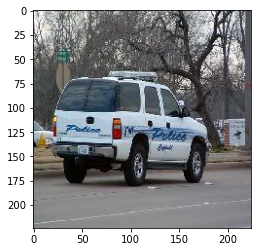

In [3]:
#Reading the first image from folder

image = cv2.imread('train/148.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [4]:
# This shows the shape of the image (rows, columns,chanel) since the image is colored
image.shape

(224, 224, 3)

## Preprocessing the image

#### We will make use of Image Data Generator to create bacthes of the tensor images.

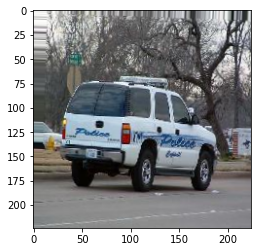

In [5]:
# Transforming the image
image_gen = ImageDataGenerator(
    rotation_range=20, #By 20%
    width_shift_range=0.1, #By 10%
    height_shift_range=0.1, #By 10%
    shear_range=0.20, #By 20%
    fill_mode='nearest',
    horizontal_flip=True,
    rescale=1/255
)

# showing the transformation
plt.imshow(image_gen.random_transform(image))

In [6]:
#Reading the file in

train_em=pd.read_csv('train.csv')
test_em=pd.read_csv('test.csv')

#Reading the first rows in our data
train_em.head()


,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


In [7]:
test_em.head()

,image_names,emergency_or_not
0,1960.jpg,0
1,668.jpg,1
2,2082.jpg,0
3,808.jpg,1
4,1907.jpg,0


In [8]:
# labels to string

train_em['emergency_or_not'] = train_em['emergency_or_not'].astype(str)
test_em['emergency_or_not'] = test_em['emergency_or_not'].astype(str)

train_em.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   image_names       1646 non-null   object
 1   emergency_or_not  1646 non-null   object
dtypes: object(2)
memory usage: 25.8+ KB


In [9]:
train_generator=image_gen.flow_from_dataframe(dataframe=train_em[:1150], # training data specification
                                              directory=train_dir, # directory path
                                              x_col='image_names', # name of images specification
                                              y_col='emergency_or_not', # labels specification
                                              class_mode='binary', # using double classification
                                              target_size=(224,224), # resizing the image
                                              batch_size=50 # specify batch size
                                             )

validation_generator=image_gen.flow_from_dataframe(dataframe=train_em[1150:], # training data specification
                                                   directory=train_dir, # directory path
                                                   x_col='image_names', # name of images specification
                                                   y_col='emergency_or_not', # labels specification
                                                   class_mode='binary', # using double classification
                                                   target_size=(224,224), # resizing the image
                                                   batch_size=50 # specify batch size
                                                  )

Found 1150 validated image filenames belonging to 2 classes.
Found 496 validated image filenames belonging to 2 classes.


### Constructing the Model

In [10]:
# instantiate model 1
model = models.Sequential()
# model architecture
model.add(layers.Conv2D(filters=16,
                        kernel_size=(3,3),
                        padding='same',
                        activation='relu',
                        input_shape=(224, 224, 3)))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Flatten())

model.add(layers.Dense(units=100, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=1, activation='sigmoid'))

In [11]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 100)               20070500  
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                        

In [12]:
# initiating the second model
model_2 = models.Sequential()

# model architecture
model_2.add(layers.Conv2D(filters=16,
                        kernel_size=(3,3),
                        padding='same',
                        activation='relu',
                        input_shape=(224, 224, 3)))
model_2.add(layers.MaxPool2D(pool_size=(2,2)))

model_2.add(layers.Conv2D(filters=32,
                        kernel_size=(3,3),
                        padding='same',
                        activation='relu'))
model_2.add(layers.MaxPool2D(pool_size=(2,2)))

model_2.add(layers.Flatten())

model_2.add(layers.Dense(units=100, activation='relu'))
model_2.add(layers.Dropout(0.2))
model_2.add(layers.Dense(units=1, activation='sigmoid'))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 100)              

### Training the Fitting the model

In [13]:
history = model.fit_generator(
    train_generator,epochs = 10,
    validation_data = validation_generator)

C:\Users\admin\AppData\Local\Temp\ipykernel_10632\2904718872.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
23/23 [==============================] - 123s 5s/step - loss: 5.0333 - accuracy: 0.5339 - val_loss: 0.8331 - val_accuracy: 0.6169
Epoch 2/10
23/23 [==============================] - 57s 2s/step - loss: 0.7605 - accuracy: 0.5783 - val_loss: 0.6482 - val_accuracy: 0.6069
Epoch 3/10
23/23 [==============================] - 52s 2s/step - loss: 0.6583 - accuracy: 0.6183 - val_loss: 0.6363 - val_accuracy: 0.6573
Epoch 4/10
23/23 [==============================] - 49s 2s/step - loss: 0.6410 - accuracy: 0.6461 - val_loss: 0.6278 - val_accuracy: 0.6895
Epoch 5/10
23/23 [==============================] - 55s 2s/step - loss: 0.6376 - accuracy: 0.6461 - val_loss: 0.5926 - val_accuracy: 0.6754
Epoch 6/10
23/23 [==============================] - 52s 2s/step - loss: 0.6191 - accuracy: 0.6704 - val_loss: 0.5730 - val_accuracy: 0.6956
Epoch 7/10
23/23 [==============================] - 47s 2s/step - loss: 0.5963 - accuracy: 0.6983 - val_loss: 0.5648 - val_accuracy: 0.7339
Epoch 8/10
23/23 [=

In [14]:
# view metrics
metrics = pd.DataFrame(history.history)
metrics

,loss,accuracy,val_loss,val_accuracy
0,5.033256,0.533913,0.833103,0.616935
1,0.760548,0.578261,0.648223,0.606855
2,0.658276,0.618261,0.636251,0.657258
3,0.641040,0.646087,0.627830,0.689516
4,0.637578,0.646087,0.592560,0.675403
5,0.619088,0.670435,0.572995,0.695565
6,0.596307,0.698261,0.564790,0.733871
7,0.598933,0.687826,0.552860,0.731855
8,0.572297,0.726087,0.523183,0.750000
9,0.544506,0.722609,0.590907,0.681452


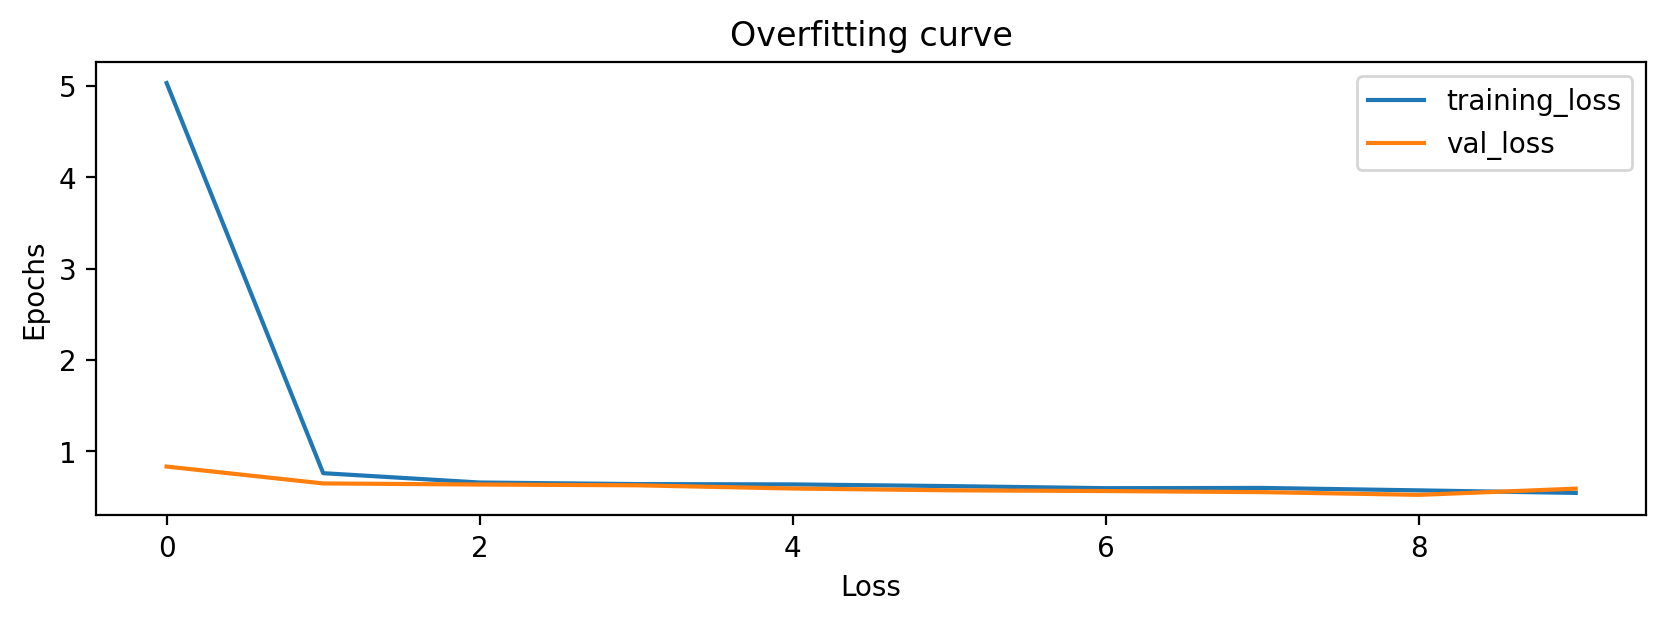

In [15]:
# checking for overfitting

em_history = pd.DataFrame(history.history)

plt.figure(dpi=200, figsize = (10,3))

plt.plot(em_history['loss'], label='training_loss')

plt.plot(em_history['val_loss'], label='val_loss')

plt.xlabel('Loss')

plt.ylabel('Epochs')

plt.legend()

plt.title('Overfitting curve')

plt.show()

In [16]:
#  compile model
model_2.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics='accuracy')

In [17]:
history_2 = model_2.fit_generator(
    train_generator,
    epochs=10,
    validation_data=validation_generator)

C:\Users\admin\AppData\Local\Temp\ipykernel_10632\2829762230.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_2 = model_2.fit_generator(


Epoch 1/10
23/23 [==============================] - 72s 3s/step - loss: 1.9401 - accuracy: 0.5200 - val_loss: 0.6428 - val_accuracy: 0.6673
Epoch 2/10
23/23 [==============================] - 53s 2s/step - loss: 0.6308 - accuracy: 0.6417 - val_loss: 0.5951 - val_accuracy: 0.7117
Epoch 3/10
23/23 [==============================] - 52s 2s/step - loss: 0.6086 - accuracy: 0.6913 - val_loss: 0.5479 - val_accuracy: 0.7278
Epoch 4/10
23/23 [==============================] - 54s 2s/step - loss: 0.5869 - accuracy: 0.7009 - val_loss: 0.5300 - val_accuracy: 0.7500
Epoch 5/10
23/23 [==============================] - 53s 2s/step - loss: 0.5398 - accuracy: 0.7478 - val_loss: 0.5137 - val_accuracy: 0.7560
Epoch 6/10
23/23 [==============================] - 54s 2s/step - loss: 0.5183 - accuracy: 0.7478 - val_loss: 0.4754 - val_accuracy: 0.7964
Epoch 7/10
23/23 [==============================] - 56s 2s/step - loss: 0.5179 - accuracy: 0.7496 - val_loss: 0.4798 - val_accuracy: 0.7641
Epoch 8/10
23/23 [==

### Evaluating the model

In [18]:
# Evaluating the model
test_generator=image_gen.flow_from_dataframe(dataframe=test_em, # Specify training data
                                              directory=test_dir, #path directory
                                              x_col='image_names', # image names
                                              y_col='emergency_or_not', # labels
                                              class_mode='binary', # double classification 
                                              target_size=(224,224), # dimension of the image to be resized
                                              batch_size=706  
                                              )

Found 706 validated image filenames belonging to 2 classes.


In [19]:
# Using model 1 to make a prediction
preds = model.predict(test_generator[0][0])

23/23 [==============================] - 5s 193ms/step


In [20]:
#  converting the predictions
preds = [0 if x[0] < 0.5 else 1 for x in preds]

In [21]:
# true labels
true_labels = test_generator[0][1]

In [22]:
#  Generating a calssifcation report

print(classification_report(true_labels, preds))

              precision    recall  f1-score   support

         0.0       0.85      0.56      0.68       408
         1.0       0.59      0.87      0.70       298

    accuracy                           0.69       706
   macro avg       0.72      0.72      0.69       706
weighted avg       0.74      0.69      0.69       706



### Creating MODEL_1 Confusion Matrix


Text(0.5, 1.0, 'Confusion Matrix for MODEL_1')

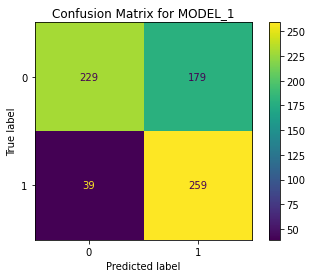

In [23]:
conf_mat = confusion_matrix(true_labels, preds)

ax = ConfusionMatrixDisplay(conf_mat)

ax.plot()

plt.title('Confusion Matrix for MODEL_1')

### Creating MODEL 2 Confusion Matrix


In [24]:
# generating predcitions for model 2
preds = model_2.predict(test_generator[0][0])

23/23 [==============================] - 6s 263ms/step


In [25]:
# converting the predictions
preds = [0 if x[0] < 0.5 else 1 for x in preds]
# true labels

In [26]:
# true labels
true_labels = test_generator[0][1]
# Generating a calssifcation report
print(classification_report(true_labels, preds))

              precision    recall  f1-score   support

         0.0       0.86      0.74      0.79       408
         1.0       0.70      0.83      0.76       298

    accuracy                           0.78       706
   macro avg       0.78      0.78      0.78       706
weighted avg       0.79      0.78      0.78       706



Text(0.5, 1.0, 'Confusion Matrix for MODEL_2')

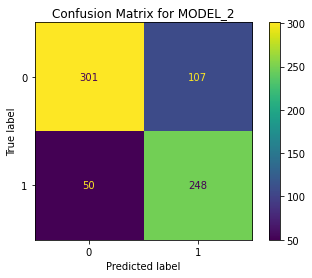

In [27]:
conf_met = confusion_matrix(true_labels, preds)

ax = ConfusionMatrixDisplay(conf_met)

ax.plot()

plt.title('Confusion Matrix for MODEL_2')

### Increasing the number of layers in the model